In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
import torch
from datetime import datetime, timezone
import logging

logging.basicConfig(
    level=logging.INFO,  # Set the logging level
    format='%(asctime)s - %(levelname)s - %(message)s',  # Format for the log messages
    handlers=[
        logging.StreamHandler()  # Log to the console
    ]
)

%reload_ext autoreload
%autoreload 2
from core_data_prep.core_data_prep import DataPreparer
from core_data_prep.validations import Validator

from data.raw.retrievers.alpaca_markets_retriever import AlpacaMarketsRetriever
from data.raw.retrievers.stooq_retriever import StooqRetriever
from config.constants import *
from data.processed.dataset_creation import DatasetCreator
from data.processed.indicators import *
from data.processed.targets import Balanced3ClassClassification
from data.processed.normalization import ZScoreOverWindowNormalizer, ZScoreNormalizer, MinMaxNormalizer
from data.processed.dataset_pytorch import DatasetPytorch
from modeling.trainer import Trainer
from modeling.evaluate import evaluate_lgb_regressor, evaluate_torch_regressor, evaluate_torch_regressor_multiasset

from modeling.rl.environment import PortfolioEnvironment
from modeling.rl.state import State
from modeling.rl.agent import RlAgent
from modeling.rl.algorithms.policy_gradient import PolicyGradient
from modeling.rl.actors.actor import RlActor
from modeling.rl.actors.signal_predictor_actor import SignalPredictorActor
from modeling.rl.actors.high_energy_low_friction_actor import HighEnergyLowFrictionActor
from modeling.rl.actors.xsmom_actor import XSMomActor
from modeling.rl.actors.tsmom_actor import TSMomActor
from modeling.rl.actors.blsw_actor import BLSWActor
from modeling.rl.actors.market_actor import MarketActor
from modeling.rl.trajectory_dataset import TrajectoryDataset
from modeling.rl.metrics import MetricsCalculator, DEFAULT_METRICS
from modeling.rl.reward import EstimatedReturnReward
from modeling.rl.loss import SumLogReturnLoss, ReinforceLoss
from modeling.rl.visualization.wealth_plot import plot_cumulative_wealth
from modeling.rl.visualization.position_plot import plot_position_heatmap
from config.experiments.cur_experiment import config

torch.backends.cudnn.benchmark = config.train_config.cudnn_benchmark

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [2]:
# retriever = AlpacaMarketsRetriever(download_from_gdrive=False, timeframe=config.data_config.frequency)

# retrieval_result = retriever.bars_with_quotes(
#     symbol_or_symbols=config.data_config.symbol_or_symbols, 
#     start=config.data_config.start, 
#     end=config.data_config.end)

# retrieval_result = retriever.bars_with_quotes(
#     symbol_or_symbols=['AAPL', 'XLY'], 
#     start=config.data_config.start, 
#     end=config.data_config.end)

retriever = StooqRetriever(download_from_gdrive=False)
retrieval_result = retriever.bars(start=config.data_config.start)

In [31]:
start_year = 2014
price_2010 = {asset: df[df['date'].dt.year == start_year].iloc[0]['close'] for asset, df in retrieval_result.items() if len(df[df['date'].dt.year == start_year]) > 0}
price_2019 = {asset: df.iloc[-1]['close'] for asset, df in retrieval_result.items()}
asset_return = {asset: price_2019[asset] / price_2010[asset] for asset in price_2010}
np.array(list(asset_return.values())).mean()

2.1583053078603367

In [4]:
data_preparer = DataPreparer(
    normalizer=config.data_config.normalizer,
    missing_values_handler=config.data_config.missing_values_handler,
    in_seq_len=config.data_config.in_seq_len,
    frequency=str(config.data_config.frequency),
    validator=Validator(),
    backend='threading'
)

In [5]:
(X_train, y_train, statistics_train), (X_val, y_val, statistics_val), (X_test, y_test, statistics_test) = \
    data_preparer.get_experiment_data(
        data=retrieval_result,
        start_date=config.data_config.start,
        end_date=config.data_config.end,
        features=config.data_config.features,
        statistics=config.data_config.statistics,
        target=config.data_config.target,
        train_set_last_date=config.data_config.train_set_last_date,
        val_set_last_date=config.data_config.val_set_last_date,
    )

X_train.shape, y_train.shape, statistics_train['next_return'].shape, \
    X_val.shape, y_val.shape, statistics_val['next_return'].shape, \
    X_test.shape, y_test.shape, statistics_test['next_return'].shape

2025-11-11 13:18:50,977 - INFO - Using monolithic slices with -60 timestamps
2025-11-11 13:18:51,279 - INFO - Found 9968 train slices, 502 val slices, 1258 test slices
2025-11-11 13:18:51,279 - INFO - Trained per-asset targets
2025-11-11 13:18:51,424 - INFO - Input data validated!
2025-11-11 13:18:54,205 - INFO - Filled data validated!
2025-11-11 13:18:56,279 - INFO - Normalised features validated!
2025-11-11 13:18:56,514 - INFO - X validated!
2025-11-11 13:18:56,613 - INFO - Target mean: 0.5494360327720642
2025-11-11 13:18:56,613 - INFO - Target validated!
2025-11-11 13:18:56,642 - INFO - Statistics 'next_return' validated!
2025-11-11 13:18:56,688 - INFO - Statistics 'volatility' validated!
2025-11-11 13:18:56,713 - INFO - Statistics 'spread' validated!
2025-11-11 13:18:56,988 - INFO - Input data validated!
2025-11-11 13:18:57,255 - INFO - Filled data validated!
2025-11-11 13:18:57,835 - INFO - Normalised features validated!
2025-11-11 13:18:57,847 - INFO - X validated!
2025-11-11 13:

((15249, 30, 30, 16),
 (15249, 30),
 (15249, 30),
 (640, 30, 30, 16),
 (640, 30),
 (640, 30),
 (1736, 30, 30, 16),
 (1736, 30),
 (1736, 30))

In [6]:
# from observability.mlflow_integration import log_experiment


# log_experiment(
#     config=config, 
#     validator_snapshots=data_preparer.validator.snapshots
#     # model=model, 
#     # history=history,
# )

In [7]:
next_return_train, spread_train, volatility_train, \
    next_return_val, spread_val, volatility_val, \
    next_return_test, spread_test, volatility_test = \
        statistics_train['next_return'], statistics_train['spread'], statistics_train['volatility'], \
        statistics_val['next_return'], statistics_val['spread'], statistics_val['volatility'], \
        statistics_test['next_return'], statistics_test['spread'], statistics_test['volatility']

In [8]:
# daily_slices = data_preparer._get_daily_slices(retrieval_result, config.data_config.start, config.data_config.end, 
#     Constants.Data.TRADING_DAY_LENGTH_MINUTES  + data_preparer.in_seq_len + data_preparer.normalizer.window + 30)

# per_asset_target = data_preparer._train_target_per_asset(
#             config.data_config.target,
#             daily_slices,
#             n_timestamps_per_slice=Constants.Data.TRADING_DAY_LENGTH_MINUTES
#         )

# X, y, statistics = data_preparer.transform_data_for_inference( 
#                                       data=daily_slices[1],
#                                       n_timestamps=Constants.Data.TRADING_DAY_LENGTH_MINUTES,
#                                       features=config.data_config.features,
#                                       include_target_and_statistics=True,
#                                       statistics=config.data_config.statistics,
#                                       per_asset_target=per_asset_target,
#                                       n_jobs=os.cpu_count() // 2
#                                       )

In [9]:
# dataset_creator = DatasetCreator(
#     features=config.data_config.features,
#     target=config.data_config.target,
#     normalizer=config.data_config.normalizer,
#     missing_values_handler=config.data_config.missing_values_handler,
#     train_set_last_date=config.data_config.train_set_last_date, 
#     val_set_last_date=config.data_config.val_set_last_date,
#     cutoff_time=config.data_config.cutoff_time,
#     in_seq_len=config.data_config.in_seq_len,
#     multi_asset_prediction=config.data_config.multi_asset_prediction,
# )

# X_train, y_train, next_return_train, spread_train, volatility_train, \
#     X_val, y_val, next_return_val, spread_val, volatility_val, \
#     X_test, y_test, next_return_test, spread_test, volatility_test \
#         = dataset_creator.create_dataset_numpy(retrieval_result)

# X_train.shape, y_train.shape, next_return_train.shape, spread_train.shape, volatility_train.shape, \
#     X_val.shape, y_val.shape, next_return_val.shape, spread_val.shape, volatility_val.shape, \
#         X_test.shape, y_test.shape, next_return_test.shape, spread_test.shape, volatility_test.shape

In [10]:
# 	    next_return, spread, volatility
# train (0.00062720885, 0.00025727754, 0.000789116)
# val   (0.0011397429, 0.0002572774, 0.0014156421)
# test  (0.0005497588, 0.0002572774, 0.00068560627)

In [11]:
np.abs(next_return_train).mean(), spread_train.mean(), volatility_train.mean()

(0.04944889, 0.0, 0.011072977)

In [12]:
np.abs(next_return_train).mean(), spread_train.mean(), volatility_train.mean()

(0.04944889, 0.0, 0.011072977)

In [13]:
np.abs(next_return_val).mean(), spread_val.mean(), volatility_val.mean()

(0.042916786, 0.0, 0.009740075)

In [14]:
np.abs(next_return_test).mean(), spread_test.mean(), volatility_test.mean()

(0.04415454, 0.0, 0.009769131)

In [15]:
train_loader = DatasetPytorch(X_train, y_train, learning_task='regression').as_dataloader(
    batch_size=config.train_config.batch_size,
    shuffle=config.train_config.shuffle,
    num_workers=config.train_config.num_workers,
    prefetch_factor=config.train_config.prefetch_factor,
    pin_memory=config.train_config.pin_memory,
    persistent_workers=config.train_config.persistent_workers,
    drop_last=config.train_config.drop_last
)
val_loader = DatasetPytorch(X_val, y_val, learning_task='regression').as_dataloader(
    batch_size=config.train_config.batch_size,
    shuffle=config.train_config.shuffle,
    num_workers=config.train_config.num_workers,
    prefetch_factor=config.train_config.prefetch_factor,
    pin_memory=config.train_config.pin_memory,
    persistent_workers=config.train_config.persistent_workers,
    drop_last=config.train_config.drop_last
)

In [16]:
model = config.model_config.model
model

TemporalSpatial(
  (lstm): LSTM(16, 64, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [17]:
config

ExperimentConfig(data_config=DataConfig(symbol_or_symbols=['AAPL', 'AMD', 'BABA', 'BITU', 'C', 'CSCO', 'DAL', 'DIA', 'GLD', 'GOOG', 'IJR', 'MARA', 'MRVL', 'MU', 'NEE', 'NKE', 'NVDA', 'ON', 'PLTR', 'PYPL', 'QLD', 'QQQ', 'QQQM', 'RKLB', 'RSP', 'SMCI', 'SMH', 'SOXL', 'SOXX', 'SPXL', 'SPY', 'TMF', 'TNA', 'TQQQ', 'TSLA', 'UBER', 'UDOW', 'UPRO', 'VOO', 'WFC', 'XBI', 'XLC', 'XLE', 'XLI', 'XLK', 'XLU', 'XLV', 'XLY', 'XOM', 'XRT'], frequency=<alpaca.data.timeframe.TimeFrame object at 0x799ddb529a60>, start=datetime.datetime(1970, 1, 2, 0, 0, tzinfo=zoneinfo.ZoneInfo(key='America/New_York')), end=datetime.datetime(2019, 1, 1, 0, 0, tzinfo=zoneinfo.ZoneInfo(key='America/New_York')), train_set_last_date=datetime.datetime(2012, 1, 1, 0, 0, tzinfo=zoneinfo.ZoneInfo(key='America/New_York')), val_set_last_date=datetime.datetime(2014, 1, 1, 0, 0, tzinfo=zoneinfo.ZoneInfo(key='America/New_York')), features={'log_ret': <function <lambda> at 0x799e662b8f40>, 'hl_range': <function <lambda> at 0x799ddb5bdc6

In [18]:
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=config.train_config.loss_fn,
    optimizer=config.train_config.optimizer,
    scheduler=config.train_config.scheduler,
    num_epochs=config.train_config.num_epochs,
    early_stopping_patience=config.train_config.early_stopping_patience,
    device=config.train_config.device,
    metrics=config.train_config.metrics,
    save_path=config.train_config.save_path
)

In [19]:
# 0.1154
# 0.3397

In [20]:
model, history = trainer.train()

2025-11-11 13:19:08,523 - INFO - Epoch 1/20
2025-11-11 13:19:12,359 - INFO - Train Loss: 0.1902         
2025-11-11 13:19:12,359 - INFO - Train Rmse: 0.4350
2025-11-11 13:19:12,359 - INFO - Val   Loss: 0.2669
2025-11-11 13:19:12,360 - INFO - Val   Rmse: 0.5165
2025-11-11 13:19:12,360 - INFO - 
2025-11-11 13:19:12,361 - INFO - Epoch 2/20
2025-11-11 13:19:15,229 - INFO - Train Loss: 0.1788         
2025-11-11 13:19:15,229 - INFO - Train Rmse: 0.4225
2025-11-11 13:19:15,229 - INFO - Val   Loss: 0.2375
2025-11-11 13:19:15,230 - INFO - Val   Rmse: 0.4872
2025-11-11 13:19:15,230 - INFO - 
2025-11-11 13:19:15,231 - INFO - Epoch 3/20
2025-11-11 13:19:18,021 - INFO - Train Loss: 0.1772         
2025-11-11 13:19:18,021 - INFO - Train Rmse: 0.4206
2025-11-11 13:19:18,022 - INFO - Val   Loss: 0.2420
2025-11-11 13:19:18,022 - INFO - Val   Rmse: 0.4919
2025-11-11 13:19:18,022 - INFO - 
2025-11-11 13:19:18,022 - INFO - Epoch 4/20
2025-11-11 13:19:20,806 - INFO - Train Loss: 0.1763         
2025-11-11

In [21]:
trajectory_length = 1
horizon = 30
train_trajectory_loader = TrajectoryDataset(X_train, next_return_train, spread_train, volatility_train, \
        trajectory_length=trajectory_length, horizon=horizon, shift_data_within_horizon=True).as_dataloader(
    batch_size=8, 
    shuffle=True,
    num_workers=8,
    prefetch_factor=4,
    pin_memory=True,
    persistent_workers=True,
    drop_last=True,
)
val_trajectory_loader = TrajectoryDataset(X_val, next_return_val, spread_val, volatility_val, \
        trajectory_length=trajectory_length, horizon=horizon).as_dataloader(
    batch_size=1, 
    shuffle=False,
    num_workers=8,
    prefetch_factor=4,
    pin_memory=True,
    persistent_workers=True,
    drop_last=False,
)
test_trajectory_loader = TrajectoryDataset(X_test, next_return_test, spread_test, volatility_test, \
        trajectory_length=trajectory_length, horizon=horizon).as_dataloader(
    batch_size=1, 
    shuffle=False,
    num_workers=8,
    prefetch_factor=4,
    pin_memory=True,
    persistent_workers=True,
    drop_last=False,
)

In [26]:
env = PortfolioEnvironment(
    reward_function=EstimatedReturnReward(fee=0.001, spread_multiplier=0.0),
)

actor = RlActor(
    model,
    n_assets=len(retrieval_result),
    train_signal_predictor=False,
).to(device)

signal_predictor_actor = SignalPredictorActor(
    model, 
    trade_asset_count=1,
    train_signal_predictor=False
).to(device)

market_actor = MarketActor().to(device)

rl_agent = RlAgent(
    actor, 
    env
)

metrics_calculator = MetricsCalculator(
    metrics=DEFAULT_METRICS
)

policy_gradient = PolicyGradient(
    rl_agent, 
    train_trajectory_loader, 
    val_trajectory_loader, 
    metrics_calculator=metrics_calculator,
    optimizer=torch.optim.AdamW(
        [p for p in actor.parameters() if p.requires_grad], 
        lr=1e-3,
        weight_decay=1e-5,
        amsgrad=True),
    scheduler=None,
    loss_fn=ReinforceLoss(use_baseline=False),
    num_epochs=10,
    device=device
)

In [32]:
# policy_gradient.train()

In [28]:
print('Val set evaluation')
epoch_loss, realized_returns_signal_predictor, actions_signal_predictor = policy_gradient.evaluate(signal_predictor_actor)

Val set evaluation


2025-11-11 13:22:28,583 - INFO - [PolicyGradient] [VAL] Epoch 0/10 — CumulativeReturn: 0.4209, MeanReturnPercentage: 1.6490, ARR: inf, AVOL: 9.0582, MDD: -0.0409, ASR: inf, CR: inf, DDR: inf, SoR: 1.0201


[PolicyGradient] [VAL] Epoch 0/10 — Loss: -32.3707


In [29]:
print('Test set evaluation')
epoch_loss, realized_returns_signal_predictor, actions_signal_predictor = policy_gradient.evaluate(signal_predictor_actor, test_trajectory_loader)

Test set evaluation


2025-11-11 13:22:30,252 - INFO - [PolicyGradient] [VAL] Epoch 0/10 — CumulativeReturn: 1.0027, MeanReturnPercentage: 1.2462, ARR: inf, AVOL: 9.1240, MDD: -0.0716, ASR: inf, CR: inf, DDR: inf, SoR: 0.5907


[PolicyGradient] [VAL] Epoch 0/10 — Loss: -64.0035


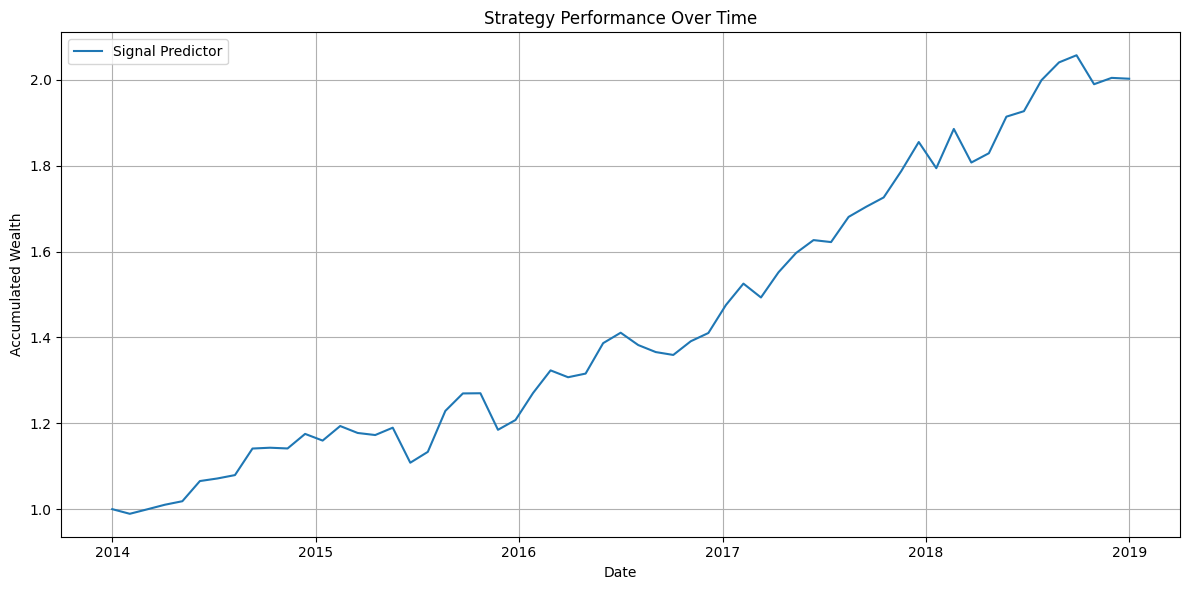

In [30]:
plot_cumulative_wealth(
    returns_dict={
        'Signal Predictor': realized_returns_signal_predictor,
    }, 
    start_time=config.data_config.val_set_last_date, 
    end_time=config.data_config.end
)

In [30]:
import copy  # Local import to avoid polluting global namespace unnecessarily
state_dict = (
    model.module.state_dict()
        if isinstance(model, torch.nn.DataParallel)
    else model.state_dict()
)

# Keep a local copy of the best weights so we can return the best model
# after training finishes, without needing to reload from disk.
best_model_state = copy.deepcopy(state_dict)

# Persist to disk if a save_path was provided
torch.save(state_dict, "best_model.pth")